## Cài đặt thư viện

In [115]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

### Hiển thị tập dữ liệu

          Lớp  Số Lượng     Tỷ Lệ
0  belly_pain        36  0.210526
1     burping        27  0.157895
2  discomfort        36  0.210526
3      scared        30  0.175439
4       tired        42  0.245614
5       tổng       171  1.000000


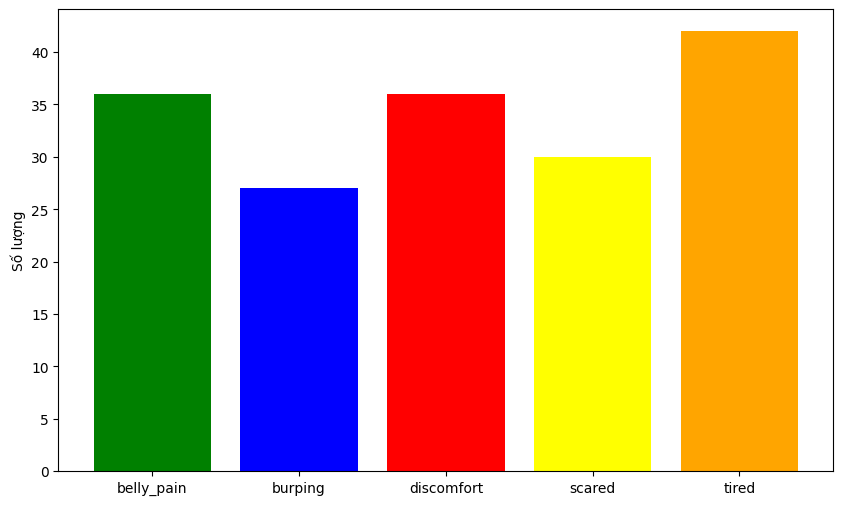

In [132]:
dataset_dir = 'data_bbcry_or_not'
# Đếm số lượng file trong mỗi thư mục (ứng với mỗi class)
class_counts = {}
for class_folder in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_folder)
    if os.path.isdir(class_path):
        num_files = len(os.listdir(class_path))
        class_counts[class_folder] = num_files

# Tạo DataFrame từ dữ liệu đã lấy
data = {
    'Lớp': list(class_counts.keys()),
    'Số Lượng': list(class_counts.values()),
}

total_count = sum(class_counts.values())
data['Tỷ Lệ'] = [count / total_count for count in data['Số Lượng']]
data['Tỷ Lệ'].append(1.0)  # Tỷ lệ cho tổng

data['Lớp'].append('tổng')
data['Số Lượng'].append(total_count)

df = pd.DataFrame(data)
print(df)

# Vẽ biểu đồ cột
labels = df['Lớp'][:-1] 
counts = df['Số Lượng'][:-1]  
colors = ['green', 'blue', 'red', 'yellow'] + ['orange'] * (len(labels) - 2)  

plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color=colors)
plt.ylabel('Số lượng')
plt.show()

### 1. Tiền xử lý dữ liệu

In [117]:
baby_cry_path = 'data_bbcry_or_not/baby cry'
environment_sound_path = 'data_bbcry_or_not/environment sound'

# Hàm chuẩn hóa độ dài tín hiệu âm thanh về 5 giây
def normalize_audio_length(y, sr, target_duration=5):
    target_length = int(sr * target_duration)
    
    if len(y) > target_length:
        # Nếu tín hiệu dài hơn 5s, cắt bớt
        y = y[:target_length]
    elif len(y) < target_length:
        # Nếu tín hiệu ngắn hơn 5s, thêm padding
        padding = target_length - len(y)
        y = np.pad(y, (0, padding), mode='constant')
    
    return y

In [118]:
# n_mfcc = 12
# n_fft = 1024  # setting the FFT size to 1024
# hop_length = 15*16 # 25ms*16khz samples has been taken
# win_length = 30*16 #25ms*16khz samples has been taken for window length
# window = 'hann' #hann window used
# n_chroma=12
# n_mels=128
# n_bands=7 #we are extracting the 7 features out of the spectral contrast
# fmin=100
# bins_per_ocatve=12

In [119]:
# def extract_features(y, sr):    
#     mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12,n_fft=n_fft,hop_length=hop_length,win_length=win_length,window=window).T,axis=0)
#     mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr,n_fft=n_fft, hop_length=hop_length, win_length=win_length, window='hann',n_mels=n_mels).T,axis=0)
#     stft = np.abs(librosa.stft(y))
#     chroma = np.mean(librosa.feature.chroma_stft(S=stft, y=y, sr=sr).T,axis=0)
#     contrast = np.mean(librosa.feature.spectral_contrast(S=stft, y=y, sr=sr,n_fft=n_fft,
#                                                     hop_length=hop_length, win_length=win_length,
#                                                     n_bands=n_bands, fmin=fmin).T,axis=0)
#     tonnetz =np.mean(librosa.feature.tonnetz(y=y, sr=sr).T,axis=0)
#     features = np.concatenate((mfcc, chroma, mel, contrast, tonnetz))
#     # print(features.shape)
#     return features

### 2. Trích xuất đặc trưng

In [120]:
def extract_features(y, sr):
    win_length = int(0.03 * sr)
    hop_length = win_length // 2
    n_fft = 2048
    
    # Trích xuất Mel Scale
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, n_mels=15)
    mel_scale = mel_spectrogram.mean(axis=1)  # Tính trung bình dọc theo trục thứ nhất (trục tần số)

    # Trích xuất MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12, hop_length=hop_length, n_fft=n_fft)
    mfcc_mean = mfccs.mean(axis=1)  # Tính trung bình dọc theo trục thứ nhất (trục MFCC)

    # Trích xuất Constant-Q Chromagram với điều chỉnh tham số
    fmin = librosa.note_to_hz('C2')  # Tần số tối thiểu khoảng 65Hz
    n_bins = 36  # Giảm số lượng tần số bin
    cqt = librosa.cqt(y, sr=sr, hop_length=hop_length, fmin=fmin, n_bins=n_bins)
    chroma = librosa.feature.chroma_cqt(C=np.abs(cqt), sr=sr)
    chroma_mean = chroma.mean(axis=1)  # Tính trung bình dọc theo trục thứ nhất (trục chroma)

    # Kết hợp các đặc trưng
    features = np.concatenate([mel_scale, mfcc_mean])

    return features

### Đọc dữ liệu và gán nhãn

In [121]:
def load_data(directory, label):
    features = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            filepath = os.path.join(directory, filename)
            y, sr = librosa.load(filepath, sr=16000)
            
            # Chuẩn hóa độ dài tín hiệu
            y = normalize_audio_length(y, sr)
            
            # Trích xuất đặc trưng và gán nhãn
            features.append(extract_features(y, sr))
            labels.append(label)
    
    return features, labels

In [122]:
# # Tạo tập dữ liệu
adult_features, adult_labels = load_data(environment_sound_path, label=0)
baby_features, baby_labels = load_data(baby_cry_path, label=1)

# # Kết hợp dữ liệu
X = np.array(baby_features + adult_features)
y = np.array(baby_labels + adult_labels)

In [123]:
# Kiểm tra kích thước của các mảng nhãn và đặc trưng
print("Shape of features array:", X.shape)
print("Shape of labels array:", y.shape)

Shape of features array: (200, 27)
Shape of labels array: (200,)


### Tạo tập dữ liệu huấn luyện

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [125]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(140, 27)
(140,)
(60, 27)
(60,)


### 3. Huấn luyện mô hình

Model: Random Forest, Accuracy: 1.000000, F1 score: 1.000000
Model: K-Nearest Neighbors, Accuracy: 0.950000, F1 score: 0.949790
Model: Decision Tree, Accuracy: 0.983333, F1 score: 0.983338
             Algorithm  Accuracy Score  F1 Score
0        Random Forest        1.000000  1.000000
1  K-Nearest Neighbors        0.950000  0.949790
2        Decision Tree        0.983333  0.983338


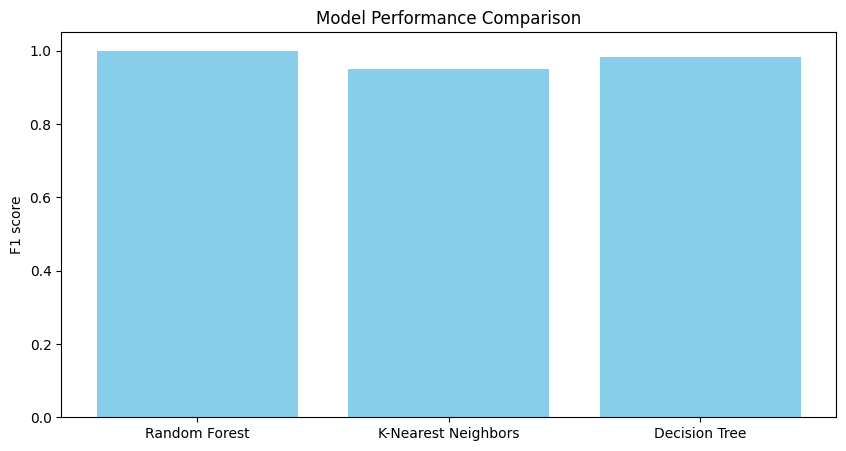

In [126]:
# Khởi tạo và huấn luyện các mô hình
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}
results = []
# Huấn luyện và đánh giá các mô hình
for model_name, model in models.items():
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')
    # Train the model on the training data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)  
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Calculate F1 score (weighted)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Model: {model_name}, Accuracy: {accuracy:.6f}, F1 score: {f1:.6f}")
    results.append({'Algorithm': model_name, 'Accuracy Score': accuracy, 'F1 Score': f1})

# Chuyển kết quả sang DataFrame
results_df = pd.DataFrame(results)

# Hiển thị bảng kết quả
print(results_df)

# Vẽ biểu đồ độ chính xác
plt.figure(figsize=(10, 5))
plt.bar(results_df['Algorithm'], results_df['F1 Score'], color='skyblue')
plt.title('Model Performance Comparison')
plt.ylabel('F1 score')
plt.show()

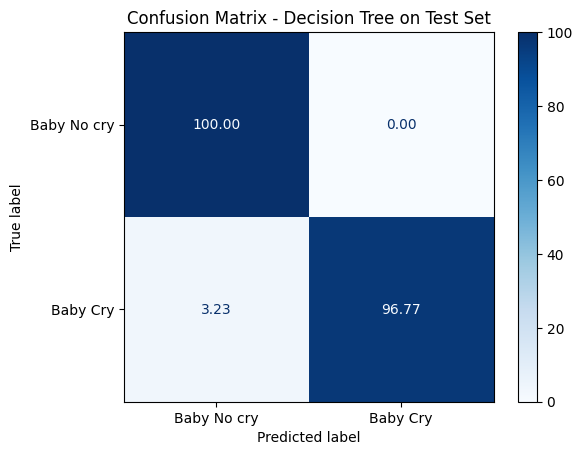

In [127]:
# Huấn luyện mô hình Random Forest
decisiontree_model = DecisionTreeClassifier(random_state=42)
decisiontree_model.fit(X_train, y_train)

# Dự đoán và tính ma trận nhầm lẫn
y_pred = decisiontree_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=['Baby No cry', 'Baby Cry'])
disp.plot(cmap='Blues', values_format=".2f")  
plt.title("Confusion Matrix - Decision Tree on Test Set")
plt.show()

### Ma trận nhầm lẫn

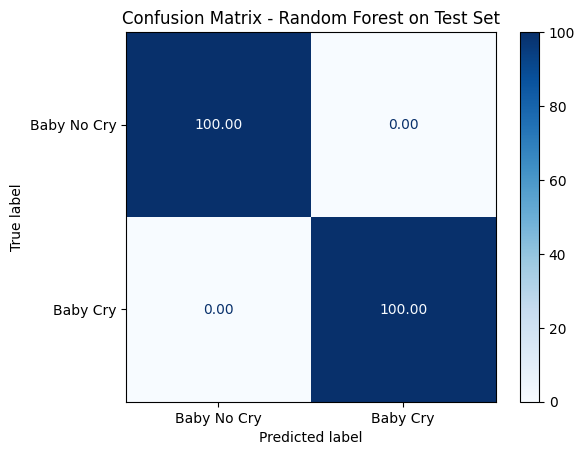

In [128]:
# Huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Dự đoán và tính ma trận nhầm lẫn
y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=['Baby No Cry', 'Baby Cry'])
disp.plot(cmap='Blues', values_format=".2f")  
plt.title("Confusion Matrix - Random Forest on Test Set")
plt.show()

### Lưu mô hình

In [129]:
import joblib

model_filename = 'decision_model_detection.pkl'

# Lưu mô hình
joblib.dump(decisiontree_model, model_filename)

print(f"Mô hình đã được lưu thành công tại {model_filename}")

Mô hình đã được lưu thành công tại decision_model_detection.pkl


### Tải mô hình

In [130]:
# import joblib
# model_filename = 'randomforest_model.pkl'
# # Tải mô hình đã lưu
# loaded_model = joblib.load(model_filename)

# # Sử dụng mô hình để dự đoán
# y_pred = loaded_model.predict(X_test)

# print("Mô hình đã được tải và sẵn sàng sử dụng.")

In [131]:
import joblib
# Hàm dự đoán cho nhiều tệp
def predict_multiple_wav_files(model, directory):
    predictions = {}
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            filepath = os.path.join(directory, filename)
            y, sr = librosa.load(filepath, sr=16000)
            y = normalize_audio_length(y, sr)
            features = extract_features(y, sr).reshape(1, -1)

            prediction = model.predict(features)
            predictions[filename] = prediction[0]
    
    return predictions

# Tải mô hình chỉ một lần
model = joblib.load('decision_model_detection.pkl')

# Thực hiện dự đoán cho tất cả các tệp trong thư mục
wav_directory = 'testing_function1'  # Thay đường dẫn thư mục chứa tệp .wav
predictions = predict_multiple_wav_files(model, wav_directory)

# In kết quả dự đoán
for filename, label in predictions.items():
    print(f"{filename}: Predicted Label = {label}")

1-36402-A-23.wav: Predicted Label = 0
1-36929-A-47.wav: Predicted Label = 0
1-37226-A-29.wav: Predicted Label = 0
1-38559-A-14.wav: Predicted Label = 0
1-38560-A-14.wav: Predicted Label = 0
1-39835-A-9.wav: Predicted Label = 0
1-39835-B-9.wav: Predicted Label = 0
1-39901-A-11.wav: Predicted Label = 0
1-39901-B-11.wav: Predicted Label = 0
1-39923-A-1.wav: Predicted Label = 0
1-39937-A-28.wav: Predicted Label = 0
442655__josephvm__baby-girl-crying.wav: Predicted Label = 0
4be720ce-a5e5-4a48-930f-a212f8a239f6-1434774947458-1.7-f-48-hu.wav: Predicted Label = 1
4cefc13c-e7c0-4b5a-bddb-c40c103e640a-1431583459308-1.7-f-26-hu.wav: Predicted Label = 1
4cefc13c-e7c0-4b5a-bddb-c40c103e640a-1431583470764-1.7-f-26-hu.wav: Predicted Label = 1
4f09a209-71bc-4f57-88d5-a599392ad9d9-1430724137656-1.7-m-04-hu.wav: Predicted Label = 1
5afc6a14-a9d8-45f8-b31d-c79dd87cc8c6-1430757081034-1.7-m-48-hu.wav: Predicted Label = 1
5b49f19f-a3a7-411e-bb32-755da3cbd6f0-1430029971483-1.7-m-48-hu.wav: Predicted Label =